In [216]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, f1_score, classification_report, plot_confusion_matrix, make_scorer, recall_score, accuracy_score, precision_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer, make_column_transformer

%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
y = pd.read_csv('../../src/data/y_dataframe.csv', index_col= 0, squeeze= True)
X = pd.read_csv('../../src/data/X_dataframe.csv', index_col= 0)

In [86]:
# From previous notebook it was discovered the total minutes was directly correlated to the charge so we dropped the eve minutes and day minutes. 
# Also state didnt seem to play a huge impportance so we took it out to reduce calculation time. 

In [98]:
X.drop(columns=['total day minutes', 'total eve minutes', 'state'], axis=1, inplace= True)

<img src='../report/figures/RandomForestClassifier(max_features=0.5, random_state=42)Feature_importance.png' width=600/>

In [202]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42, test_size = .2)
X_t, X_val, y_t, y_val = train_test_split(X_train,y_train, random_state=42, test_size = .2)

In [203]:
numerical_features = X_t.select_dtypes(exclude='object').columns
categorical_features = X_t.select_dtypes(include='object').columns

In [256]:
def model_output(model, X_t, X_val, y_t, y_val):
    '''Can be used on final test and train validation''
    input:   model, X_t, X_val, y_t, y_val
    or 
    input:   model, X_train, X_test, y_train, y_test
    '''
    
    model.fit(X_t, y_t)
    y_hat = model.predict(X_val)
    
    print(f'''The Cross Val accuracy is: {cross_val_score(estimator = model, X = X_t,y = y_t, cv = 3, scoring = 'accuracy').mean()}''')
    print(f'The test Accuracy is: {accuracy_score(y_val, y_hat)}')
    print(confusion_matrix(y_val, y_hat))
    print(classification_report(y_val, y_hat))

    return

# Pipeline

In [257]:
preprocess = make_column_transformer(
    (OneHotEncoder(sparse = False, drop ='first'), categorical_features), remainder = 'passthrough')

In [278]:
pipe_forest = Pipeline([
    ('pp', preprocess),
    ('ss', StandardScaler()),
    ('sm', SMOTE(random_state= 42)),
    ('rf', RandomForestClassifier(random_state= 42, max_features= 10, min_samples_split = 2, n_estimators= 300))])

# Random forest model

In [279]:
model_output(pipe_forest, X_train, X_test, y_train, y_test)

The Cross Val accuracy is: 0.9343646233410013
The test Accuracy is: 0.9535232383808095
[[552  14]
 [ 17  84]]
              precision    recall  f1-score   support

       False       0.97      0.98      0.97       566
        True       0.86      0.83      0.84       101

    accuracy                           0.95       667
   macro avg       0.91      0.90      0.91       667
weighted avg       0.95      0.95      0.95       667



# Random forest with grid models

In [262]:
grid_forest = {
    'rf__min_samples_split': [2, 3, 5, 10], 
    'rf__n_estimators' : [100, 300],
    'rf__max_depth': [3, 5, 15, 25],
    'rf__max_features': ['sqrt', 5, 10, .5]
}

In [263]:
scorers_forest = {
    'recall_score': make_scorer(recall_score),
    'precision_score': make_scorer(precision_score),
    'f1': make_scorer(f1_score)
    }

# Maximizing f1

In [264]:
grid_search_f1 = GridSearchCV(pipe_forest, grid_forest, scoring=scorers_forest, refit='f1',
                           cv=3, return_train_score=True, n_jobs=-1)

model_output(grid_search_f1, X_t, X_val, y_t, y_val)

The Cross Val accuracy is: 0.9254320107235064
The test Accuracy is: 0.9382022471910112
[[440  16]
 [ 17  61]]
              precision    recall  f1-score   support

       False       0.96      0.96      0.96       456
        True       0.79      0.78      0.79        78

    accuracy                           0.94       534
   macro avg       0.88      0.87      0.88       534
weighted avg       0.94      0.94      0.94       534



In [265]:
grid_search_f1.best_params_

{'rf__max_depth': 25,
 'rf__max_features': 10,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 300}

In [266]:
grid_search_recall = GridSearchCV(pipe_forest, grid_forest, scoring=scorers_forest, refit='recall_score',
                           cv=3, return_train_score=True, n_jobs=-1)

model_output(grid_search_recall, X_t, X_val, y_t, y_val)

The Cross Val accuracy is: 0.8621355889674663
The test Accuracy is: 0.9082397003745318
[[420  36]
 [ 13  65]]
              precision    recall  f1-score   support

       False       0.97      0.92      0.94       456
        True       0.64      0.83      0.73        78

    accuracy                           0.91       534
   macro avg       0.81      0.88      0.84       534
weighted avg       0.92      0.91      0.91       534



In [267]:
grid_search_recall.best_params_

{'rf__max_depth': 5,
 'rf__max_features': 10,
 'rf__min_samples_split': 3,
 'rf__n_estimators': 300}

In [268]:
grid_search_precision = GridSearchCV(pipe_forest, grid_forest, scoring=scorers_forest, refit='precision_score',
                           cv=3, return_train_score=True, n_jobs=-1)

model_output(grid_search_precision, X_t, X_val, y_t, y_val)

The Cross Val accuracy is: 0.9277761269916734
The test Accuracy is: 0.9419475655430711
[[439  17]
 [ 14  64]]
              precision    recall  f1-score   support

       False       0.97      0.96      0.97       456
        True       0.79      0.82      0.81        78

    accuracy                           0.94       534
   macro avg       0.88      0.89      0.89       534
weighted avg       0.94      0.94      0.94       534



In [270]:
grid_search_precision.best_params_

{'rf__max_depth': 25,
 'rf__max_features': 0.5,
 'rf__min_samples_split': 3,
 'rf__n_estimators': 300}

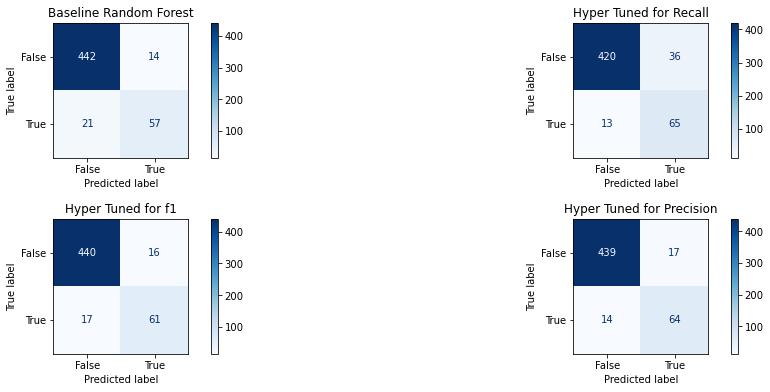

In [273]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))
fig.tight_layout(pad=4.0)

axes[0,0].set_title("Baseline Random Forest")
axes[1,0].set_title("Hyper Tuned for f1")
axes[0,1].set_title("Hyper Tuned for Recall")
axes[1,1].set_title("Hyper Tuned for Precision")

plot_confusion_matrix(pipe_forest, X_val, y_val, ax=axes[0,0], cmap="Blues")
plot_confusion_matrix(grid_search_f1, X_val, y_val, ax=axes[1,0], cmap="Blues")
plot_confusion_matrix(grid_search_recall, X_val, y_val, ax=axes[0,1], cmap="Blues")
plot_confusion_matrix(grid_search_precision, X_val, y_val, ax=axes[1,1], cmap="Blues")

Hyper Tuned for Precision seems to give the best overall results. Ideally we want our False negative as low as possible like the one hypertuned for recall, but not at the cost of affecting FP that much. 